In [1]:
# get environment variables
import os
import sys
from dotenv import load_dotenv, find_dotenv
import datetime

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

sys.path.append(os.environ.get('srcdir'))

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.resample_roms import low_to_high
%aimport features.resample_roms

In [3]:
import xarray as xr
import matplotlib.pyplot as plt

hr_grd_path = os.path.join(os.environ.get("prodir"),'waom1_small_grd.nc')
hr_grd = xr.open_dataset(hr_grd_path)

lr_grd_path = os.path.join(os.environ.get("prodir"),'waom10_small_grd.nc')
lr_grd = xr.open_dataset(lr_grd_path)

lr_sbc_path =  os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom10_v2.0_frc','waom10_small_sbc.nc')
lr_sbc = xr.open_dataset(lr_sbc_path)

In [58]:

#month = ['jan','feb']#'feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#daysPerMonth = [1,2]#,28,31,30,31,30,31,31,30,31,30,31]

In [63]:
#month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

month = ['may','jun','jul','aug','sep','oct','nov','dec']
daysPerMonth = [31,30,31,31,30,31,30,31]


#dayOfYear =1
dayOfYear = 121

for month,days in zip(month,daysPerMonth):
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    print('processing days of year: ',daysOfYear)
    
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,hr_grd.eta_rho.size,hr_grd.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,hr_grd.eta_rho.size,hr_grd.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,hr_grd.eta_u.size,hr_grd.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,hr_grd.eta_v.size,hr_grd.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
    
    for day_idx in range(days):
        
        print('processing day: ',day_idx+1)
        
        for var,gt in zip(['shflux','swflux','sustr','svstr'],['rho','rho','u','v']):
            
            print('resampling variable: ',var,' with grid type: ',gt)
            ds[var][day_idx] = resample(lr_grd['lon_'+gt].values,lr_grd['lat_'+gt].values,hr_grd['lon_'+gt].values,hr_grd['lat_'+gt].values,lr_sbc[var][day_idx].values)
            
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf file

    out_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_v2.0_frc','waom1_sbc_'+month+'.nc')
    
    print("Saving month to "+out_path)
    ds.to_netcdf(out_path,'w')
    
    dayOfYear+=days

processing days of year:  [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151]
processing day:  1
resampling variable:  shflux  with grid type:  rho
resampling variable:  swflux  with grid type:  rho
resampling variable:  sustr  with grid type:  u
resampling variable:  svstr  with grid type:  v
processing day:  2
resampling variable:  shflux  with grid type:  rho
resampling variable:  swflux  with grid type:  rho
resampling variable:  sustr  with grid type:  u
resampling variable:  svstr  with grid type:  v
processing day:  3
resampling variable:  shflux  with grid type:  rho
resampling variable:  swflux  with grid type:  rho
resampling variable:  sustr  with grid type:  u
resampling variable:  svstr  with grid type:  v
processing day:  4
resampling variable:  shflux  with grid type:  rho
resampling variable:  swflux  with grid type:  rho
resampling variable:  sustr  with grid type:  u
resampling variable:  svstr

RuntimeError: NetCDF: HDF error

In [62]:
ds.to_netcdf(out_path,'w')

In [ ]:
from scipy.ndimage.filters import gaussian_filter, uniform_filter
mask_tmp = grid_ds.mask_rho.copy()
mask_tmp[:] = b
mask_tmp.values = gaussian_filter(mask_tmp,30)

plt.close()
mask_tmp.plot()
plt.show()

In [4]:
in_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_v2.0_frc','waom1_sbc_jan.nc')
jan = xr.open_dataset(in_path)['sustr'].isel(sms_time=0)

In [7]:
plt.close()
jan.shflux.plot(size=15)
plt.show()

AttributeError: 'DataArray' object has no attribute 'shflux'

In [5]:
from scipy.ndimage.filters import gaussian_filter
smoothed = gaussian_filter(jan.values,50)

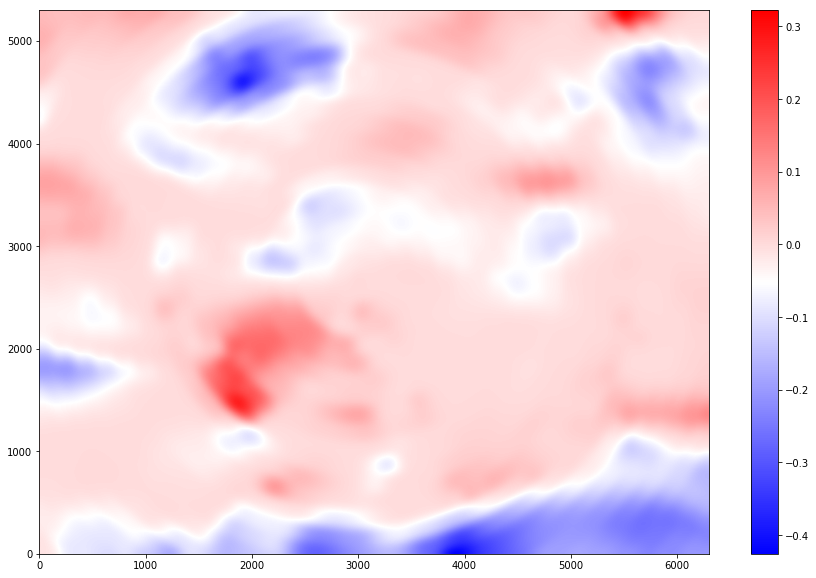

In [6]:
plt.close()
plt.figure(figsize=(15,10))
plt.pcolormesh(smoothed,cmap=plt.cm.bwr)
plt.colorbar()
plt.show()